In [1]:
#This notebook is licensed under the GNU General Public License, Version 2 (GPL-2.0).
#See the `LICENSE_GPL` file in the root directory of this project for the full text.

import torch
from Model import Multi_VAE
import numpy as np
from Data_Handler import Data_Handler
from matplotlib import pyplot as plt

properties = [
 'eAT',
 'eMBD',
 'eNN',
 'eKIN',
 'eNE',
 'eEE',
 'eXX',
 'EGAP',
 'POL',
 'DIP',
 'HOMO_0',
 'LUMO_0',
 'HOMO_1',
 'LUMO_1',
 'HOMO_2',
 'LUMO_2',
 'dimension'
    ]

reproduce_paper = True

if reproduce_paper:
    paper_path = '_paper'
    properties = ['eAT', 'eMBD', 'eXX', 'mPOL', 'eNN', 'eNE', 'eEE', 'eKIN', 'DIP', 'HLgap', 'HOMO_0', 'LUMO_0', 'HOMO_1', 'LUMO_1', 'HOMO_2', 'LUMO_2', 'dimension']

else:
    paper_path = ''
data = Data_Handler(
)

p_means = torch.load('./data{}/data/properties_means.pt'.format(paper_path))
p_stds = torch.load('./data{}/data/properties_stds.pt'.format(paper_path))

Here load model, do prediction and histogram of CM relative error in % (a bit cumbersome code but it is to clean the output CMs)

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v1.9.4. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file checkpoints_wimsy5/epoch=2597-step=145487.ckpt`


0.6524984072085191
0.8177846545917903
tensor(5.4573)


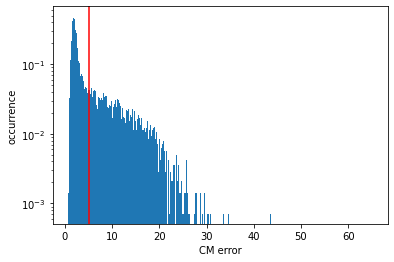

In [2]:
import copy
PATH = './models_saved/masked/epoch=2597-step=145487.ckpt'

modello = Multi_VAE.load_from_checkpoint(
    PATH,
    map_location=torch.device('cpu'),
    structures_dim = len(torch.load('./data{}/data/data_val/CMs.pt'.format(paper_path))[0,:]),
    properties_dim = len(torch.load('./data{}/data/data_val/properties.pt'.format(paper_path))[0,:]),
    latent_size = 21,
    extra_dim = 32 - len(torch.load('./data{}/data/data_val/properties.pt'.format(paper_path))[0,:]),
    initial_lr = 1e-3,
    properties_means = p_means,
    properties_stds = p_stds,
    beta_init = 3.,
    beta_0=1,
    beta_1=1.1,
    alpha = 2,
    decay = .995,
    freq=0
)

# Uncomment this if you want the original model

# if reproduce_paper == True:
#     PATH='./special/VAE_reduced_21'
#     modello.VAE.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
#     PATH='./special/prop_ecoder_reduced_21'
#     modello.property_encoder.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

modello.eval()
modello.freeze()
CMs_test = torch.load('./data{}/data/data_test/CMs.pt'.format(paper_path))
properties_test = torch.load('./data{}/data/data_test/properties.pt'.format(paper_path))
normalized_properties_test = (properties_test - p_means)/p_stds
reconstructed_CMs_, Z = modello.test_generation_from_Y(normalized_properties_test)
reconstructed_CMs = reconstructed_CMs_
reconstructed_CMs[reconstructed_CMs<=0] = 0.
n = len(reconstructed_CMs[0,:])
lun=int((-1+(1+2*4*n)**0.5)/2)
resized_CMs = torch.zeros(reconstructed_CMs.size(0), lun, lun).to(torch.float32)
i,j=np.triu_indices(lun)
resized_CMs[:, i, j] = reconstructed_CMs.to(torch.float32)
resized_CMs[:, j, i] = reconstructed_CMs.to(torch.float32)
mask = copy.deepcopy(torch.diagonal(resized_CMs, dim1=1, dim2=2))
mask[mask<=18.5] = 0
mask[mask>18.5] = 1
mask = torch.einsum('ij, ik -> ijk', mask, mask)
resized_CMs = torch.mul(resized_CMs, mask)
reconstructed_CMs = resized_CMs[:,i,j]
L1_relative = 100*(reconstructed_CMs - CMs_test).abs().sum(dim = 1)/CMs_test.abs().sum(dim = 1)
L1 = L1_relative
plt.hist(L1.numpy(), bins = 500, density=True)
plt.yscale('log')
plt.axvline(5, c = 'r')
plt.xlabel('CM error')
plt.ylabel('occurrence')
print(len(L1[L1<5])/len(L1))
print(len(L1[L1<10])/len(L1))
print(L1.mean())

I use this cell to compute the rmsds

In [3]:
from invert_CM import *
df = get_rmsds(CMs_test, reconstructed_CMs)

100%|██████████| 10987/10987 [00:06<00:00, 1692.45it/s]


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


And here histogram of RMSD

0.6424281668326296

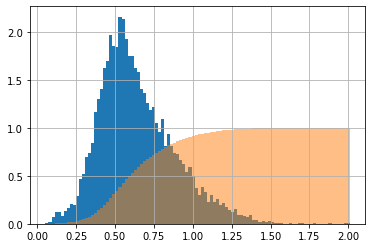

In [4]:
df[df['rmsd']!=float('inf')]['rmsd'].hist(bins = 100, density = True)
df[df['rmsd']!=float('inf')]['rmsd'].hist(bins = 100, cumulative = True, density = True, alpha = .5)
df[df['rmsd']!=float('inf')]['rmsd'].mean()

Check portion of test set under .7 RMSD

In [5]:
len(df[df['rmsd']<.7])/len(df)

0.6517702739601346

Check that delta z correlates with RMSD

[0.2013474479317665, 0.38095156103372574, 0.560555674135685, 0.7401597872376442, 0.9197639003396034, 1.0993680134415627, 1.2789721265435219, 1.458576239645481, 1.6381803527474403, 1.8177844658493996] [0.49278083511059756, 0.5011823590515697, 0.5866829096745262, 0.7103620122859796, 0.7943650617067929, 0.8852933771157883, 0.9236245826726749, 1.1167921194095378, nan, nan]


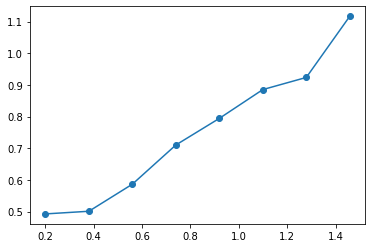

In [6]:
new_z, _ = modello.VAE.encode(reconstructed_CMs)
deltas = torch.norm(new_z-Z, dim = 1)
ints = 10
dD = ((deltas.max()-deltas.min())/ints).numpy()
medie = []
stands = []
x = []
for i in range(0,ints):
    tmp = df['rmsd'][abs(deltas.numpy() - (deltas.min().numpy() + 0.5*dD + i*dD))<.25*dD]
    x.append(deltas.min().numpy() + 0.5*dD + i*dD)
    medie.append(tmp[tmp!=float('inf')].mean())
    stands.append(tmp[tmp!=float('inf')].std())
plt.plot(x, medie, marker = 'o')


Here you can use the Zs from before to do some PCA like in the paper

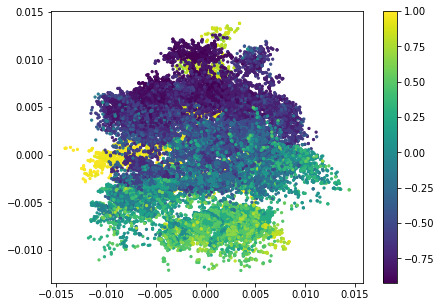

In [7]:
import numpy as np
from sklearn.decomposition import PCA

plt.figure(figsize=(7,5))
total_CMs = torch.load('./{}data/CMs_total.pt'.format(paper_path))
total_properties = torch.load('./{}data/properties_total.pt'.format(paper_path))
Z, _ = modello.VAE.encode(total_CMs.to(torch.float32))
#Z = (Z-Z.mean(axis = 0))/Z.std(axis = 0) #if you want to normalize before PCA, here I don't because I want to show the intuition for linear interpolation later on
X = Z.numpy().T
pca = PCA(n_components=2)
pca.fit(X)
i = np.where(np.array(properties)=='eXX')[0][0]
normalized_props = (total_properties - p_means)/p_stds
plt.scatter(pca.components_[0], pca.components_[1], s = 5, c = np.tanh(normalized_props[:,i].numpy())) 
plt.colorbar()

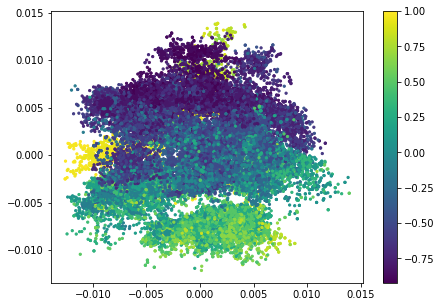

In [8]:
import numpy as np
from sklearn.decomposition import PCA
plt.figure(figsize=(7,5))
total_CMs = torch.load('./{}data/CMs_total.pt'.format(paper_path))
total_properties = torch.load('./{}data/properties_total.pt'.format(paper_path))
normalized_props = (total_properties - p_means)/p_stds
Z, _ = modello.property_encoder(normalized_props.to(torch.float32))
#Z = (Z-Z.mean(axis = 0))/Z.std(axis = 0) #if you want to normalize before PCA, here I don't because I want to show the intuition for linear interpolation later on
X = Z.numpy().T
pca2 = PCA(n_components=2)
pca2.fit(X)
i = np.where(np.array(properties)=='eXX')[0][0]
plt.scatter(pca2.components_[0], pca2.components_[1], s = 5, c = np.tanh(normalized_props[:,i].numpy())) 
plt.colorbar()

Weird and convoluted way to optimize overlap of PCAs over generic affine transformation and reflection

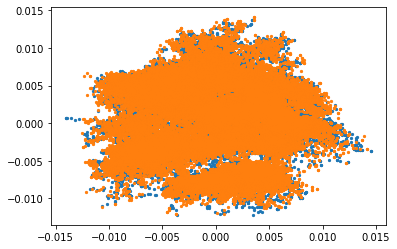

In [ ]:
from scipy.optimize import minimize

def affine(x, theta = 0, a =0, b = 0):
    x = torch.tensor(x.tolist())
    c = torch.tensor([a, b])
    A = torch.tensor([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    affine_x = torch.einsum('jk, ik -> ij', A.to(torch.float32), x.to(torch.float32)) + c.to(torch.float32)
    return affine_x
    
def cost_function(arr = np.array([0,0,0])):
    theta = arr[0]
    a = arr[1]
    b = arr[2]
    y = torch.tensor(pca.components_.T.tolist())
    z = affine(pca2.components_.T, theta, a, b)
    norm = torch.linalg.norm(y-z, dim = 1)**2
    norm = norm[norm<norm.max()]
    return (norm).mean().item()

minfunc = 1e4

for i in [-1,1]:
    
    def cost_function(arr = np.array([0.,0.,0.])):
        theta = arr[0]
        a = arr[1]
        b = arr[2]
        y = torch.tensor(pca.components_.T.tolist())
        y [:,1] = y[:,1]*i
        z = affine(pca2.components_.T, theta, a, b)
        return (torch.linalg.norm(y-z, dim = 1)**2).sum().item()
    
    min = minimize(cost_function, np.array([0.,0.,0.]), method='Nelder-Mead', tol=1e-5)
    if min.fun < minfunc:
        minfunc = min.fun
        minx = min.x
        sign = i

temp = pca2.components_.T
temp[:,0] = temp[:,0]*sign
pca_comp2 = affine(temp, *minx.tolist()).T
plt.scatter(pca.components_[0], pca.components_[1], s = 5)
plt.scatter(pca_comp2[0], pca_comp2[1], s = 5)

Here a stupid scatter plot of $log(error_{CM})$ and RMSD 

0.2172121603705939 0.3568831860820797


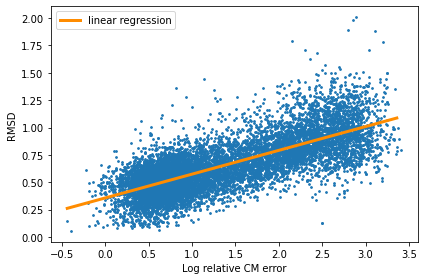

In [9]:
from scipy import stats
rmsds = df['rmsd'].values
logerr = np.log(L1_relative)[rmsds!=float('inf')]
rmsds = rmsds[rmsds!=float('inf')]
res = stats.linregress(logerr, rmsds)
plt.scatter(np.log(L1_relative), df['rmsd'], s = 3)
x = np.arange(logerr.min(), logerr.max(), 0.1)
plt.plot(x, res.slope*x + res.intercept, c = 'darkorange', linewidth = 3, label = 'linear regression')
plt.ylabel('RMSD')
plt.xlabel('Log relative CM error')
plt.legend()
plt.tight_layout()
plt.savefig('./logcm_rmsd.pdf')

Try a couple of molecules and visualize reconstructed and original (no hydrogens)

In [13]:
from invert_CM import *
from ase import Atoms
from ase.visualize import view

k = 3
out_cm, _ = modello.test_generation_from_Y(normalized_properties_test[k,:].view(1, -1).to(torch.float32), sampling=False, normalize_latent = False)
out_cm[out_cm<=0] = 0.
n = len(out_cm[0,:])
lun=int((-1+(1+2*4*n)**0.5)/2)
resized_CMs = torch.zeros(out_cm.size(0), lun, lun).to(torch.float32)
i,j=np.triu_indices(lun)
resized_CMs[:, i, j] = out_cm.to(torch.float32)
resized_CMs[:, j, i] = out_cm.to(torch.float32)
mask = copy.deepcopy(torch.diagonal(resized_CMs, dim1=1, dim2=2))
mask[mask<=18.5] = 0
mask[mask>18.5] = 1
mask = torch.einsum('ij, ik -> ijk', mask, mask)
resized_CMs = torch.mul(resized_CMs, mask)
out_cm = resized_CMs[:,i,j]
try:
    print(df[df['rmsd']!=float('Inf')]['rmsd'].iloc[k])
except:
    pass
pos, comp = get_cartesian(out_cm[0])#reconstructed_CMs[n,:].tolist())
atom = Atoms(comp, pos)
view(atom, viewer = 'x3d')

0.5474060071383192


In [ ]:
pos, comp = get_cartesian(CMs_test[k,:].tolist())
atom = Atoms(comp, pos)
view(atom, viewer = 'x3d')

Here you can see the generated molecules from samples $\mathcal{N}(0,1)$ from latent space

In [15]:
from openbabel import openbabel as ob
from ase.io import read, write
from ase.optimize import BFGS, FIRE
from ase.calculators.dftb import Dftb
from ase.constraints import FixAtoms

# Choose your own calculator, here we had a version of SpookyNet trained on QM7-X at PBE0+MBD. In the paper we use DFTB+MBD

#from spooks.spookynet import SpookyNetCalculator, spookynet
#calc=SpookyNetCalculator(load_from="./spooks/qm7x_known_unknown_0.pth", charge=0, magmom=0)

n_comp = 10
atoms = 0

# here I load a pt file with all of the heavy atom compositions so as to avoid already present compositions, do the same for your case if you want this check
registry = torch.load('./registry_of_comp.pt')
paddin_l = 12 - len(registry[0])
pad = torch.zeros(registry.size(0), paddin_l)
registry = torch.cat((registry, pad), dim = 1)

delta_comp_min = 0

# here depending on the request in the while you can keep generating until you get new molecules
while n_comp !=1 or delta_comp_min == 0 or atoms == 8:
    z = torch.randn(1, 21)
    out_cm, _ = modello.VAE.decode(z)
    out_cm[out_cm<=0] = 0.
    n = len(out_cm[0,:])
    lun = int((-1+(1+2*4*n)**0.5)/2)
    resized_CMs = torch.zeros(out_cm.size(0), lun, lun).to(torch.float32)
    i,j=np.triu_indices(lun)
    resized_CMs[:, i, j] = out_cm.to(torch.float32)
    resized_CMs[:, j, i] = out_cm.to(torch.float32)
    mask = copy.deepcopy(torch.diagonal(resized_CMs, dim1=1, dim2=2))
    mask[mask<=18.5] = 0
    mask[mask>18.5] = 1
    mask = torch.einsum('ij, ik -> ijk', mask, mask)
    resized_CMs = torch.mul(resized_CMs, mask)
    out_cm = resized_CMs[:,i,j]
    pos, comp = get_cartesian(out_cm[0,:].tolist())
    atoms = len(comp)
    atom = Atoms(comp, pos)
    n_comp = get_connected(atom)
    if n_comp == 1:
        paddin_l = 12 - len(comp)
        pad = torch.zeros(paddin_l)
        tens_comp = torch.tensor(comp)
        tens_comp = torch.cat((tens_comp, pad), dim = 0)
        
        delta_comp_min = (tens_comp.view(1,-1) - registry).abs().sum(dim = 1).min()

write('./temp.xyz', atom)
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("xyz", "mol2")
mol = ob.OBMol()
obConversion.ReadFile(mol, "temp.xyz")  
obConversion.WriteFile(mol, 'temp.mol2')
obConversion = ob.OBConversion()
obConversion.SetInAndOutFormats("mol2", "xyz")
mol = ob.OBMol()
obConversion.ReadFile(mol, "temp.mol2")  
mol.ConnectTheDots()
mol.PerceiveBondOrders()
mol.AddHydrogens()
obConversion.WriteFile(mol, './temp.xyz')
atom = read('./temp.xyz')
c = FixAtoms(indices=[atomo.index for atomo in atom if atomo.symbol != 'H'])
atom.set_constraint(c)
atom.set_calculator(calc)
#try:
opt = FIRE(atom)
opt.run(steps = 4)
atom.set_constraint()
#opt.run(steps = 50)
#except:
#    pass
print(comp, len(comp))
view(atom, viewer = 'x3d')

/home/users/afallani/.local/lib/python3.7/site-packages/ase/calculators/calculator.py:509: FutureWarning: The keyword "ignore_bad_restart_file" is deprecated and will be removed in a future version of ASE.  Passing more than one positional argument to Calculator is also deprecated and will stop functioning in the future.  Please pass arguments by keyword (key=value) except optionally the "restart" keyword.
  'The keyword "ignore_bad_restart_file" is deprecated and '


      Step     Time          Energy         fmax
FIRE:    0 10:32:26      -89.043770        3.0930
FIRE:    1 10:32:26      -89.399780        2.8565
FIRE:    2 10:32:26      -89.926529        2.3739
FIRE:    3 10:32:26      -90.414040        1.7154
FIRE:    4 10:32:26      -90.762573        1.1999
[8, 8, 7, 7, 6, 6, 6, 6, 6] 9


Explainability section: Gradient map

In [ ]:
from torchani.utils import _get_derivatives_not_none as derivative
import copy
from torch.autograd import Variable

rmsds = df['rmsd'].values

# it will be faster if you put a low value for RMSD limit
idxs = [rmsds<0.1]

props_totest = normalized_properties_test[idxs]
grad_maps = torch.zeros_like(props_totest[0,:])

for i in tqdm(range(0,len(props_totest))): 
    input_props = Variable(props_totest[i,:], requires_grad = True)
    CM, _ = modello.test_generation_from_Y(input_props.view(1,-1))
    grad_map = torch.tensor([derivative(input_props, CM[0,j], retain_graph = True, create_graph = True).to(torch.float32).tolist() for j in range(0,len(CM[0,:]))])
    grad_map = torch.linalg.norm(grad_map, dim = 0)
    grad_maps += grad_map

grad_maps = grad_maps/len(props_totest)

100%|██████████| 12/12 [01:41<00:00,  8.46s/it]


And here we plot the attribution map

Text(0.5, 0, 'properties')

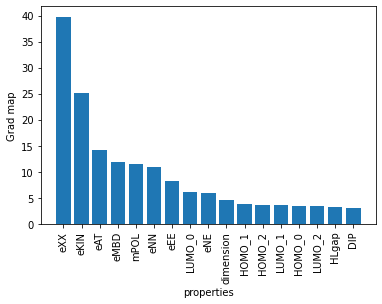

In [ ]:
id = np.flip(np.argsort(grad_maps.numpy()))
plt.bar(np.array(properties)[id], grad_maps.numpy()[id])
plt.xticks(rotation='vertical')
plt.ylabel('Grad map')
plt.xlabel('properties')